In [1]:
# if you don't run this ipynb in google colab, then comment below codes out
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing Libraries

In [2]:
#Importing suppourtive libraries for this task
import os
import numpy as np
import pandas as pd
from PIL import Image
from time import time
from matplotlib import pyplot as plt
from IPython.display import display
import os
import json
from numpy import asarray 

In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
from pathlib import Path
# choose gpu to train the model otherwise use cpu 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using:', device)

Using: cuda


### Define Datasets and Dataloaders

In [4]:
#  change the path of dataset_path, model_path and predict_path accoding to the pathes in your local computer
dataset_path = './drive/MyDrive/ASC/Datasets'
model_path = './drive//MyDrive/ASC/Models'
predict_path = './drive/MyDrive/ASC/Predict'

Path(dataset_path).mkdir(parents=True, exist_ok=True)
Path(model_path).mkdir(parents=True, exist_ok=True)
Path(predict_path).mkdir(parents=True, exist_ok=True)

In [5]:
# Data augmentation
# Transformations are used in our Defect-Detection application
transform_1 = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # transform RGB(3 channels) images to grayscale(1 channel) images 
    transforms.Resize((64,64)), # resize the input image to 64*64
    transforms.ToTensor(), # convert image to pytorch tensor

])


# Transformation function to be applied on images
# 1. transform RGB(3 channels) images to grayscale(1 channel) images
# 2. resize the input image to 64*64
# 3. Horizontally Flip the image with a probability of 30%
# 4. Randomly Rotate the image at an angle between -40 to 40 degrees.
# 5. Change the brightness and contrast of an image.
# 6. Convert Image to a Pytorch Tensor(pixel values range from 0 to 1)
# 7. Normalize the pytorch's tensor using mean & std 

mean = torch.tensor([0.5], dtype=torch.float32)
std = torch.tensor([0.5], dtype=torch.float32)

transform_2 = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=40),
    transforms.ColorJitter(brightness =.05, contrast =.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Create a dataset from the dataset folder
# change 'transform=' to choose different transformers(1 or 2)
dataset = torchvision.datasets.ImageFolder(dataset_path, transform=transform_2)

n = len(dataset)  # how many total images you have
n_test = int( n * .2 )  # number of testing images
n_train = n - n_test # number of traing images
print('traing data size:',n_train)
print('testing data size:',n_test)
# Split the dataset into train & test containing 80% and 20% images respectively.
train_dataset, test_dataset = torch.utils.data.random_split(dataset, (n_train, n_test))

# Create a Train DataLoader using Train Dataset
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4
)
# Create a Test DataLoader using Test Dataset
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4
)

traing data size: 2880
testing data size: 720


### Plot Some Samples of data

In [6]:
figsize = (16,16)

def PlotSamples(dataloader, title='Images'):
    sample_data = next(iter(dataloader))[0].to(device)
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.title(title)
    plt.imshow(np.transpose(torchvision.utils.make_grid(
        sample_data, padding=2, normalize=True
    ).cpu(), (1,2,0)))
    
    
def PlotClass(dataloader, mclass, title='Images', num=32):
    ret = []
    
    for data in dataloader.dataset:
        if data[1] == mclass:
            ret.append(data[0])
            
            if len(ret) == num:
                break
    
    plt.figure(figsize=figsize)
    plt.axis('off')
    title="Class"+ str(mclass)
    plt.title(title)
    plt.imshow(np.transpose(torchvision.utils.make_grid(
        ret, padding=2, normalize=True
    ).cpu(), (1,2,0)))
    

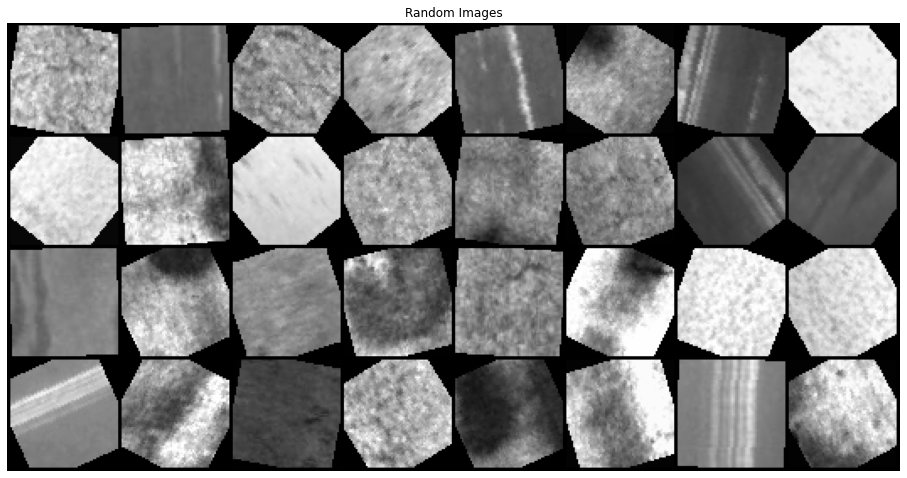

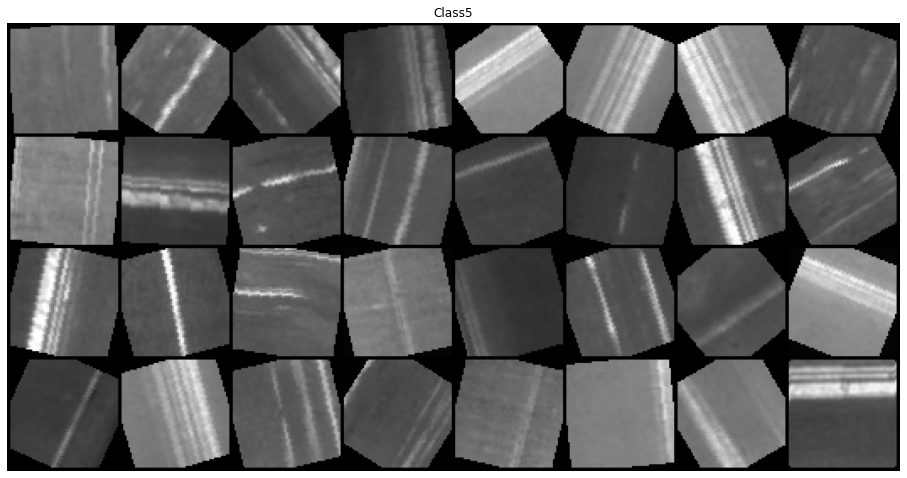

In [7]:
# randomly show some images in the training dataset
PlotSamples(train_dataloader, title="Random Images")
# show class #5 images in the training dataset
PlotClass(train_dataloader,5)

In [8]:
classes = []
for d in os.listdir(dataset_path):
    if os.path.isdir(os.path.join(dataset_path, d)) and not d.startswith('.'):
        classes.append(d) 
print ("There are ", len(classes), "classes:\n", classes)

There are  6 classes:
 ['Scratch', 'Crazing', 'Pitted Surface', 'RS', 'Inclusion', 'Patches']


### Defile Model Architecture from Scratches

In [9]:
# Convolutional neural network from scratches

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3), 
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(16, 32, kernel_size=3), 
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, kernel_size=3), 
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        ).to(device)
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.25),
            nn.Linear(2304, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 6)
        ).to(device)
        
    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x


model = MyModel().to(device)
summary(model, (1,64,64))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 62, 62]             160
              ReLU-2           [-1, 16, 62, 62]               0
         MaxPool2d-3           [-1, 16, 31, 31]               0
            Conv2d-4           [-1, 32, 29, 29]           4,640
              ReLU-5           [-1, 32, 29, 29]               0
         MaxPool2d-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 64, 12, 12]          18,496
              ReLU-8           [-1, 64, 12, 12]               0
         MaxPool2d-9             [-1, 64, 6, 6]               0
          Flatten-10                 [-1, 2304]               0
          Dropout-11                 [-1, 2304]               0
           Linear-12                  [-1, 256]         590,080
             ReLU-13                  [-1, 256]               0
          Dropout-14                  [

### Training Procedure

In [10]:
def Train(epoch, steps):
    total_loss = 0
    start_time = time()
    
    accuracy = []
    
    for i, batch in enumerate(train_dataloader, 1):
        minput = batch[0].to(device) # Get batch of images from our train dataloader
        target = batch[1].to(device) # Get the corresponding target representing types of defects
        moutput = model(minput) # output by our model
        loss = criterion(moutput, target) # compute cross entropy loss
        total_loss += loss.item()
        optimizer.zero_grad() # Clear the gradients if exists. (Gradients are used for back-propogation.)
        loss.backward() # Back propogate the losses
        optimizer.step() # Update Model parameters
        
        argmax = moutput.argmax(dim=1) # Get the class index (exp: 0, 1, 2, 3, 4 or 5) with maximum probability predicted by the model
        accuracy.append((target==argmax).sum().item() / target.shape[0]) # calculate accuracy by comparing to target tensor
        # show loss and acc during training
        if i%steps == 0:
            print('Epoch: [{}]/({}/{}), Train Loss: {:.4f}, Accuracy: {:.2f}, Time: {:.2f} sec'.format(
                epoch, i, len(train_dataloader), loss.item(), sum(accuracy)/len(accuracy), time()-start_time 
            ))
    
    return [total_loss / len(train_dataloader),sum(accuracy)/len(accuracy)]  # Returning Average Training Loss and Accuracy

### Testing Procedure

In [11]:
def Test(epoch):
    total_loss = 0
    start_time = time()

    accuracy = []
    
    with torch.no_grad(): # disable calculations of gradients for all pytorch operations inside the block
        for i, batch in enumerate(test_dataloader):
            minput = batch[0].to(device) # Get batch of images from our test dataloader
            target = batch[1].to(device) # Get the corresponding target representing types of defects
            moutput = model(minput) # output by our model
            loss = criterion(moutput, target) # compute cross entropy loss
            total_loss += loss.item()

            # To get the probabilities for different classes we need to apply a softmax operation on moutput 
            argmax = moutput.argmax(dim=1) # Find the index(exp: 0, 1, 2, 3, 4 or 5) with maximum score (which denotes class with maximum probability)
            accuracy.append((target==argmax).sum().item() / target.shape[0]) # Find the accuracy of the batch by comparing it with actual targets
            
    print('Epoch: [{}], Test Loss: {:.4f}, Accuracy: {:.2f}, Time: {:.2f} sec'.format(
        epoch, total_loss/len(test_dataloader), sum(accuracy)/len(accuracy), time()-start_time
    ))
    return [total_loss/len(test_dataloader), sum(accuracy)/len(accuracy)] # Returning Average Testing Loss and Accuracy

### Model, Optimizer & Loss Function

In [12]:
lr = 0.0001
model = MyModel().to(device)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# Loss Function
criterion = nn.CrossEntropyLoss()

### Train for 50 epochs

In [13]:
# if you want to train the model by yourself, you can uncomment below lines.

# train_loss = []
# test_loss = []
# train_acc = []
# test_acc = []
# # change the numbers of the range to choose how many epochs to train the model
# for epoch in range(1, 51):
# # '90' is the number of steps,as the batch size is 32 and the training data size is 2880
#     train = Train(epoch,90)
#     test = Test(epoch)
#     train_loss.append(train[0])
#     test_loss.append(test[0])
#     train_acc.append(train[1])
#     test_acc.append(test[1])
#     print('\n')
#     # save trained models every ten epochs
#     if epoch % 10 == 0:
#         torch.save(model, os.path.join(model_path, str(epoch)+'.pth'))

### Plot Train-Test Loss Curve

In [14]:
# if you want to show the training and testing accuracy, you can uncomment below lines.

# plt.figure(figsize=(8, 5))
# plt.plot(range(1, len(train_loss)+1), train_loss, 'g', label='Training Loss')
# plt.plot(range(1, len(test_loss)+1), test_loss, 'b', label='Testing Loss')

# plt.title('Training and Testing Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# plt.figure(figsize=(8, 5))
# plt.plot(range(1, len(train_acc)+1), train_acc, 'g', label='Training Acc')
# plt.plot(range(1, len(test_acc)+1), test_acc, 'b', label='Testing Acc')

# plt.title('Training and Testing Acc')
# plt.xlabel('Epochs')
# plt.ylabel('Acc')
# plt.legend()
# plt.show()

### Preprocess:Map Name to ID

In [15]:
translate = {
    "Crazing": "crazing", 
    "Inclusion": "inclusion", 
    "Patches": "patches", 
    "Pitted Surface": "pitted surface", 
    "RS": "rolled-in scale", 
    "Scratch": "scratches", 
}

name_map = {"cr.jpg":0,
            "in.jpg":1,
            "pat.jpg":2,
            "ps.jpg":3,
            "rs.jpg":4,
            "sc.jpg":5
            }

# translate = {x:translate[x] for x in train_dataloader.dataset.dataset.classes}
print(translate)

{'Crazing': 'crazing', 'Inclusion': 'inclusion', 'Patches': 'patches', 'Pitted Surface': 'pitted surface', 'RS': 'rolled-in scale', 'Scratch': 'scratches'}


### Attack Model

In [16]:
LABELS = ["crazing","inclusion","patches","pitted surface","rolled-in scale","scratches"]

def show(img):
    npimg = img.cpu().numpy()
    a= np.transpose(npimg, (1,2,0))
    a = a[:,:,0]
    plt.imshow(a, interpolation='nearest',cmap="gray")
    # plt.imshow(a)
def tell(image, label, model, target_label=None):
    image_tensor = image.view(1,1,64,64).to(device)
    moutput = model(image_tensor)
    moutput = nn.Softmax(dim=1)(moutput)[0]*100
    idx = moutput.argmax().data.item()
    oclass = LABELS[idx]
    moutput = moutput.int().data.cpu().numpy()
    display(image)
    print("True Label:", LABELS[label], label)
    print("Prediction:", oclass, idx)
    print("Label Probabilities:", nn.Softmax(dim=1)(model(image_tensor))[0]*100)
    print("True Label Probability:", moutput[label],'%')
    if target_label is not None:
        print("Target Label Probability:", moutput[target_label])



#### Prediction on Test Data

4


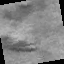

true label: rs.jpg
predicted label: rolled-in scale
confidence: 88 % 


1


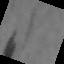

true label: in.jpg
predicted label: inclusion
confidence: 80 % 


5


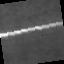

true label: sc.jpg
predicted label: scratches
confidence: 99 % 


2


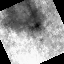

true label: pat.jpg
predicted label: patches
confidence: 99 % 


0


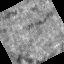

true label: cr.jpg
predicted label: crazing
confidence: 99 % 


3


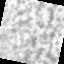

true label: ps.jpg
predicted label: pitted surface
confidence: 99 % 




In [17]:
# # Uncomment the below two lines if you want to use the pre trained model for more epochs
weight_name="50.pth"
model = torch.load(os.path.join(model_path,weight_name), map_location=device)
# model.eval()

denormalize = transforms.Compose([
    transforms.Normalize(mean = -mean/std, std = 1./std),
    transforms.ToPILImage()
])

test_image = [];
test_image_label = [];
confidence = [];
with torch.no_grad(): # disable calculations of gradients for all pytorch operations inside the block
    
    for i, impath in enumerate(os.listdir(predict_path)):   

        try:
            image = Image.open(os.path.join(predict_path, impath))
            # display(image)
        except:
            continue
        # choose transform_1 or transform_2 to tranform input image
        image = transform_2(image)
        test_image.append(image)
        test_image_label.append(impath)
        image_tensor = image.view(1,1,64,64).to(device)
        moutput = model(image_tensor)
        moutput = nn.Softmax(dim=1)(moutput)[0]*100
        idx = moutput.argmax().data.item()
        print(idx)
        oclass = list(translate.keys())[idx]
        moutput = moutput.int().data.cpu().numpy()
        display(denormalize(image))
        print("true label:", impath)
        print("predicted label:", translate[oclass])
        print("confidence:", moutput[idx], '%', '\n\n')
        confidence.append(moutput[idx])

# LABELS = ["crazing","inclusion","patches","pitted surface","rolled-in scale","scratches"]

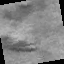

tensor([[[-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9686],
         [-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9686],
         [-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9686],
         ...,
         [-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9686],
         [-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9686],
         [-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9686]]],
       device='cuda:0')

True Label: rolled-in scale 4
Prediction: rolled-in scale 4
Label Probabilities: tensor([4.5819e-01, 2.9430e-03, 1.6837e+01, 2.5724e+00, 7.3784e+01, 6.3457e+00],
       device='cuda:0', grad_fn=<MulBackward0>)
True Label Probability: 82 %


In [18]:

test_img = test_image[0]
test_label = name_map[test_image_label[0]]
test_img = test_img.to(device)
# show(test_img)
display(denormalize(test_img))
tell(test_img, test_label, model)



#### Perturbation

Perturbation: [ 0.3  0.3 -1. ]


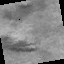

tensor([[[-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9686],
         [-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9686],
         [-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9686],
         ...,
         [-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9686],
         [-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9686],
         [-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9686]]])

True Label: rolled-in scale 4
Prediction: rolled-in scale 4
Label Probabilities: tensor([5.8561e-01, 1.3003e-04, 8.6114e-01, 7.2737e-01, 8.5142e+01, 1.2684e+01],
       device='cuda:0', grad_fn=<MulBackward0>)
True Label Probability: 97 %
Prediction confidence before attack: 88 %


Perturbation: [ 0.3  0.3 -1. ]


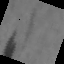

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])

True Label: inclusion 1
Prediction: inclusion 1
Label Probabilities: tensor([2.6030e-06, 4.1832e+01, 4.4477e-04, 1.0525e+00, 3.7283e+00, 5.3387e+01],
       device='cuda:0', grad_fn=<MulBackward0>)
True Label Probability: 78 %
Prediction confidence before attack: 80 %


Perturbation: [ 0.3  0.3 -1. ]


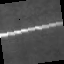

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])

True Label: scratches 5
Prediction: scratches 5
Label Probabilities: tensor([1.8340e-04, 7.2405e-03, 2.0099e-02, 2.0695e-03, 1.3410e+00, 9.8629e+01],
       device='cuda:0', grad_fn=<MulBackward0>)
True Label Probability: 99 %
Prediction confidence before attack: 99 %


Perturbation: [ 0.3  0.3 -1. ]


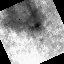

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])

True Label: patches 2
Prediction: patches 2
Label Probabilities: tensor([1.5134e-01, 1.1074e-08, 9.9742e+01, 4.3606e-04, 2.5070e-03, 1.0384e-01],
       device='cuda:0', grad_fn=<MulBackward0>)
True Label Probability: 90 %
Prediction confidence before attack: 99 %


Perturbation: [ 0.3  0.3 -1. ]


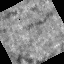

tensor([[[-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9686],
         [-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9686],
         [-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9686],
         ...,
         [-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9686],
         [-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9686],
         [-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9686]]])

True Label: crazing 0
Prediction: crazing 0
Label Probabilities: tensor([9.9889e+01, 3.3712e-11, 3.9330e-03, 2.4255e-04, 1.0660e-01, 7.5294e-06],
       device='cuda:0', grad_fn=<MulBackward0>)
True Label Probability: 91 %
Prediction confidence before attack: 99 %


Perturbation: [ 0.3  0.3 -1. ]


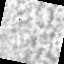

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])

True Label: pitted surface 3
Prediction: pitted surface 3
Label Probabilities: tensor([1.2035e-02, 7.7022e-02, 1.7813e+01, 8.1784e+01, 2.0972e-01, 1.0467e-01],
       device='cuda:0', grad_fn=<MulBackward0>)
True Label Probability: 98 %
Prediction confidence before attack: 99 %




In [19]:
from IPython.display import Image
def perturb(p, img):
    # Elements of p should be in range [0,1]
    img_size = img.size(1) # C x _H_ x W, assume H == W
    p_img = img.clone()
    # show(p_img)
    xy = (p[0:2].copy() * img_size).astype(int)
    xy = np.clip(xy, 0, img_size-1)
    rgb = p[2].copy()
    # rgb = np.clip(rgb, -1, 1)
    rgb=np.array(rgb, dtype='float32')
    p_img[:,xy[0],xy[1]] = torch.from_numpy(rgb)
    return p_img

def visualize_perturbation(p, img, label, model, target_label=None):
    
    p_img = perturb(p, img)
    print("Perturbation:", p)
    display(denormalize(p_img))
    tell(p_img, label, model, target_label)

for i in range(len(test_image)):

    visualize_perturbation(np.array([0.3,0.3,-1]), test_image[i], name_map[test_image_label[i]], model)
    print("Prediction confidence before attack:", confidence[i],'%')
    print("\n")

#### Untargeted and Targeted Attackes

Target Probability [Iteration 0]: 0.9460724592208862
Target Probability [Iteration 10]: 0.9454951882362366
Target Probability [Iteration 20]: 0.9444007873535156
Target Probability [Iteration 30]: 0.9444007873535156
Target Probability [Iteration 40]: 0.9440317153930664
Target Probability [Iteration 50]: 0.9439941048622131
Target Probability [Iteration 60]: 0.9439816474914551
Target Probability [Iteration 70]: 0.9439816474914551
Target Probability [Iteration 80]: 0.9439816474914551
Target Probability [Iteration 90]: 0.9439816474914551
Perturbation: [0.48782018 0.3214589  0.99999715]


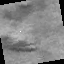

tensor([[[-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9686],
         [-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9686],
         [-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9686],
         ...,
         [-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9686],
         [-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9686],
         [-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9686]]])

True Label: rolled-in scale 4
Prediction: rolled-in scale 4
Label Probabilities: tensor([2.0872e-01, 2.8122e-03, 5.2927e-01, 9.1234e-01, 9.4398e+01, 3.9487e+00],
       device='cuda:0', grad_fn=<MulBackward0>)
True Label Probability: 94 %
Prediction confidence before attack: 88 %


Target Probability [Iteration 0]: 0.5346881747245789
Target Probability [Iteration 10]: 0.3405880033969879
Target Probability [Iteration 20]: 0.3405880033969879
Target Probability [Iteration 30]: 0.33901867270469666
Target Probability [Iteration 40]: 0.33382734656333923
Target Probability [Iteration 50]: 0.33382734656333923
Target Probability [Iteration 60]: 0.333469420671463
Target Probability [Iteration 70]: 0.33345577120780945
Target Probability [Iteration 80]: 0.33345523476600647
Target Probability [Iteration 90]: 0.3334552049636841
Perturbation: [0.57737541 0.21092357 0.99999994]


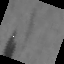

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])

True Label: inclusion 1
Prediction: scratches 5
Label Probabilities: tensor([6.6227e-04, 3.3346e+01, 9.3983e-03, 1.5463e+00, 2.9392e+01, 3.5706e+01],
       device='cuda:0', grad_fn=<MulBackward0>)
True Label Probability: 33 %
Prediction confidence before attack: 80 %


Target Probability [Iteration 0]: 0.9774158596992493
Target Probability [Iteration 10]: 0.9768216013908386
Target Probability [Iteration 20]: 0.9757910370826721
Target Probability [Iteration 30]: 0.975651204586029
Target Probability [Iteration 40]: 0.975594699382782
Target Probability [Iteration 50]: 0.9755935668945312
Target Probability [Iteration 60]: 0.9755935668945312
Target Probability [Iteration 70]: 0.9755935668945312
Target Probability [Iteration 80]: 0.9755935668945312
Target Probability [Iteration 90]: 0.9755935668945312
Perturbation: [0.76529431 0.39090162 0.99999913]


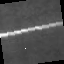

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])

True Label: scratches 5
Prediction: scratches 5
Label Probabilities: tensor([5.8625e-03, 1.7147e-05, 3.8432e-01, 7.5056e-05, 2.0504e+00, 9.7559e+01],
       device='cuda:0', grad_fn=<MulBackward0>)
True Label Probability: 97 %
Prediction confidence before attack: 99 %


Target Probability [Iteration 0]: 0.9926694631576538
Target Probability [Iteration 10]: 0.991209864616394
Target Probability [Iteration 20]: 0.9910887479782104
Target Probability [Iteration 30]: 0.9910665154457092
Target Probability [Iteration 40]: 0.9910644292831421
Target Probability [Iteration 50]: 0.9910643100738525
Target Probability [Iteration 60]: 0.9910643100738525
Target Probability [Iteration 70]: 0.9910643100738525
Target Probability [Iteration 80]: 0.9910643100738525
Target Probability [Iteration 90]: 0.9910643100738525
Perturbation: [0.37564129 0.58934569 0.99999864]


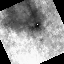

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])

True Label: patches 2
Prediction: patches 2
Label Probabilities: tensor([8.5372e-01, 1.7709e-09, 9.9106e+01, 3.1500e-04, 8.2289e-03, 3.1300e-02],
       device='cuda:0', grad_fn=<MulBackward0>)
True Label Probability: 99 %
Prediction confidence before attack: 99 %


Target Probability [Iteration 0]: 0.9871945977210999
Target Probability [Iteration 10]: 0.9869583249092102
Target Probability [Iteration 20]: 0.9869583249092102
Target Probability [Iteration 30]: 0.9869583249092102
Target Probability [Iteration 40]: 0.9869583249092102
Target Probability [Iteration 50]: 0.9869583249092102
Target Probability [Iteration 60]: 0.9869583249092102
Target Probability [Iteration 70]: 0.9869582056999207
Target Probability [Iteration 80]: 0.9869582056999207
Target Probability [Iteration 90]: 0.9869582056999207
Perturbation: [0.06466864 0.08805512 0.99999739]


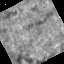

tensor([[[-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9686],
         [-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9686],
         [-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9686],
         ...,
         [-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9686],
         [-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9686],
         [-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9686]]])

True Label: crazing 0
Prediction: crazing 0
Label Probabilities: tensor([9.8696e+01, 4.4766e-10, 6.2678e-02, 8.5276e-04, 1.2385e+00, 2.1896e-03],
       device='cuda:0', grad_fn=<MulBackward0>)
True Label Probability: 98 %
Prediction confidence before attack: 99 %


Target Probability [Iteration 0]: 0.9899314641952515
Target Probability [Iteration 10]: 0.9774115085601807
Target Probability [Iteration 20]: 0.9774115085601807
Target Probability [Iteration 30]: 0.9738739132881165
Target Probability [Iteration 40]: 0.9731354713439941
Target Probability [Iteration 50]: 0.9731206893920898
Target Probability [Iteration 60]: 0.9731190204620361
Target Probability [Iteration 70]: 0.9731190204620361
Target Probability [Iteration 80]: 0.9731190204620361
Target Probability [Iteration 90]: 0.9731190204620361
Perturbation: [ 0.49644168  0.76698341 -0.99999971]


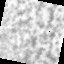

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])

True Label: pitted surface 3
Prediction: pitted surface 3
Label Probabilities: tensor([4.8259e-02, 9.8748e-03, 2.4944e+00, 9.7312e+01, 1.1362e-01, 2.1957e-02],
       device='cuda:0', grad_fn=<MulBackward0>)
True Label Probability: 97 %
Prediction confidence before attack: 99 %




In [20]:

def evaluate(candidates, img, label, model):
    preds = []
    model.eval()
    with torch.no_grad():
        for i, xs in enumerate(candidates):
            p_img = perturb(xs, img)
            p_img = p_img.view(1,1,64,64).to(device)
            moutput = model(p_img)
            moutput = nn.Softmax(dim=1)(moutput)[0]
            preds.append(moutput[label].item())
    return np.array(preds)

def evolve(candidates, F=0.5, strategy="clip"):
    gen2 = candidates.copy()
    num_candidates = len(candidates)
    for i in range(num_candidates):
        x1, x2, x3 = candidates[np.random.choice(num_candidates, 3, replace=False)]
        x_next = (x1 + F*(x2 - x3))
        if strategy == "clip":
            gen2[i] = np.clip(x_next, -1, 1)
        elif strategy == "resample":
            x_oob = np.logical_or((x_next < -1), (1 < x_next))
            x_next[x_oob] = np.random.random(3)[x_oob]
            gen2[i] = x_next
    return gen2

def attack(model, img, true_label, target_label=None, iters=100, pop_size=400, verbose=True):
    # Targeted: maximize target_label if given (early stop > 50%)
    # Untargeted: minimize true_label otherwise (early stop < 5%)
    candidates = np.random.random((pop_size,3))
    candidates[:,[2]] = np.clip(np.random.normal(0.5, 0.5, (pop_size, 1)), -1, 1)
    is_targeted = target_label is not None
    label = target_label if is_targeted else true_label
    fitness = evaluate(candidates, img, label, model)
    
    def is_success():
        return (is_targeted and fitness.max() > 0.5) or ((not is_targeted) and fitness.min() < 0.05)
    
    for iteration in range(iters):
        # Early Stopping
        if is_success():
            break
        if verbose and iteration%10 == 0: # Print progress
            print("Target Probability [Iteration {}]:".format(iteration), fitness.max() if is_targeted else fitness.min())
        # Generate new candidate solutions
        new_gen_candidates = evolve(candidates, strategy="resample")
        # Evaluate new solutions
        new_gen_fitness = evaluate(new_gen_candidates, img, label, model)
        # Replace old solutions with new ones where they are better
        successors = new_gen_fitness > fitness if is_targeted else new_gen_fitness < fitness
        candidates[successors] = new_gen_candidates[successors]
        fitness[successors] = new_gen_fitness[successors]
    best_idx = fitness.argmax() if is_targeted else fitness.argmin()
    best_solution = candidates[best_idx]
    best_score = fitness[best_idx]
    if verbose:
        visualize_perturbation(best_solution, img, true_label, model, target_label)
    return is_success(), best_solution, best_score

# Untargeted attack
for i in range(len(test_image)):
    _ = attack(model, test_image[i], name_map[test_image_label[i]])
    print("Prediction confidence before attack:", confidence[i],'%')
    print("\n")


In [21]:
# Targeted attack
# This is much harder/costlier than an untargeted attack
# For time reasons, targeted attacks below use 20 iterations
targeted_results = {}
for i in range(len(test_image)):
    for idx in range(len(LABELS)):
        if idx != name_map[test_image_label[i]]:
            targeted_results[idx] = attack(model, test_image[i], name_map[test_image_label[i]], target_label=idx, iters=20, verbose=False)
            print(LABELS[idx], idx, targeted_results[idx][0], targeted_results[idx][2])
        else:
            print(LABELS[idx], idx, "True Label")
    print("Prediction confidence before attack:", confidence[i],'%')
    print("\n")

crazing 0 False 0.005839190911501646
inclusion 1 False 3.707045834744349e-05
patches 2 False 0.009620273485779762
pitted surface 3 False 0.011506827548146248
rolled-in scale 4 True Label
scratches 5 False 0.0383666455745697
Prediction confidence before attack: 88 %


crazing 0 False 6.057871814846294e-06
inclusion 1 True Label
patches 2 False 8.770321437623352e-05
pitted surface 3 False 0.015853401273489
rolled-in scale 4 False 0.2939181923866272
scratches 5 False 0.40967437624931335
Prediction confidence before attack: 80 %


crazing 0 False 6.356684752972797e-05
inclusion 1 False 2.620325858515571e-06
patches 2 False 0.0038237213157117367
pitted surface 3 False 1.4001116142026149e-06
rolled-in scale 4 False 0.020422961562871933
scratches 5 True Label
Prediction confidence before attack: 99 %


crazing 0 False 0.008441658690571785
inclusion 1 False 2.2865137561112192e-10
patches 2 True Label
pitted surface 3 False 1.5176085980783682e-05
rolled-in scale 4 False 0.00018166682275477797
s